## Deep Learning ChatBot

### Importing Libraries 

In [1]:
import json 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D , Flatten , Dropout , Activation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

### Loading Intents Files  

In [2]:
with open('intents.json') as file:
    data = json.load(file)

### Splitting the data into sentences , labels , responses 

In [3]:
training_sentences = []
training_labels = []
labels = []
responses = []


for intent in data['intents']:
    for pattern in intent['patterns']:
        training_sentences.append(pattern)
        training_labels.append(intent['tag'])
    responses.append(intent['responses'])
    
    if intent['tag'] not in labels:
        labels.append(intent['tag'])
        
num_classes = len(labels)

In [4]:
len(set(training_labels))

44

### Encoding The Data Labels

In [124]:
lbl_encoder = LabelEncoder()
lbl_encoder.fit(training_labels)
training_labels = lbl_encoder.transform(training_labels)

### NLP Text Tokannize , clean 

In [125]:
vocab_size = 1000
embedding_dim = 16
max_len = 20
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token) # adding out of vocabulary token
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded_sequences = pad_sequences(sequences, truncating='post', maxlen=max_len)

### Neural Network Baseline

In [126]:
baseline = Sequential()
baseline.add(Dense(128, activation='relu'))
baseline.add(Dense(128, activation='relu'))
baseline.add(Dense(num_classes, activation='softmax'))


baseline.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
baseline_nn = baseline.fit(padded_sequences,np.array(training_labels), epochs=10)

Epoch 1/10
7/7 [==============================] - 0s 2ms/step - loss: 11.6937 - accuracy: 0.0251
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 6.9175 - accuracy: 0.0352
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 5.1431 - accuracy: 0.0503
Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 4.0215 - accuracy: 0.1005
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 3.4765 - accuracy: 0.1206
Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 3.2179 - accuracy: 0.1508
Epoch 7/10
7/7 [==============================] - 0s 3ms/step - loss: 3.0471 - accuracy: 0.1759
Epoch 8/10
7/7 [==============================] - 0s 3ms/step - loss: 2.8773 - accuracy: 0.1859
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 2.7433 - accuracy: 0.2312
Epoch 10/10
7/7 [==============================] - 0s 3ms/step - loss: 2.6773 - accuracy: 0.2462


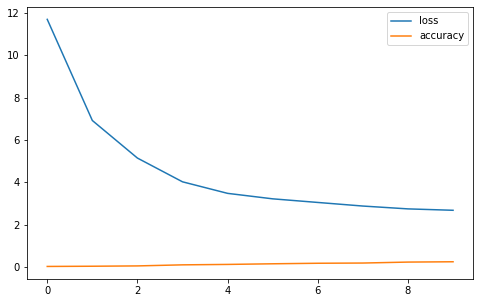

In [127]:
pd.DataFrame(baseline_nn.history).plot(figsize=(8,5))
plt.show()

### Buidling The Neural Model Using Embedding Layer 

In [128]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [129]:
model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 20, 16)            16000     
                                                                 
 global_average_pooling1d_6   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_79 (Dense)            (None, 16)                272       
                                                                 
 dense_80 (Dense)            (None, 16)                272       
                                                                 
 dense_81 (Dense)            (None, 46)                782       
                                                                 
Total params: 17,326
Trainable params: 17,326
Non-trainable params: 0
_________________________________________________

### Train The Model On Our Data
    - adding the early stop to know the proper epoch count , starting after 200

In [130]:
epochs = 300
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=200)
history = model.fit(padded_sequences, np.array(training_labels), epochs=epochs , callbacks=[es])

Epoch 1/300
7/7 [==============================] - 1s 2ms/step - loss: 3.8296 - accuracy: 0.0201
Epoch 2/300
7/7 [==============================] - 0s 2ms/step - loss: 3.8285 - accuracy: 0.0251
Epoch 3/300
7/7 [==============================] - 0s 2ms/step - loss: 3.8276 - accuracy: 0.0251
Epoch 4/300
7/7 [==============================] - 0s 4ms/step - loss: 3.8271 - accuracy: 0.0251
Epoch 5/300
7/7 [==============================] - 0s 3ms/step - loss: 3.8265 - accuracy: 0.0251
Epoch 6/300
7/7 [==============================] - 0s 3ms/step - loss: 3.8260 - accuracy: 0.0251
Epoch 7/300
7/7 [==============================] - 0s 2ms/step - loss: 3.8253 - accuracy: 0.0251
Epoch 8/300
7/7 [==============================] - 0s 2ms/step - loss: 3.8245 - accuracy: 0.0251
Epoch 9/300
7/7 [==============================] - 0s 3ms/step - loss: 3.8238 - accuracy: 0.0251
Epoch 10/300
7/7 [==============================] - 0s 4ms/step - loss: 3.8229 - accuracy: 0.0402
Epoch 11/300
7/7 [===========

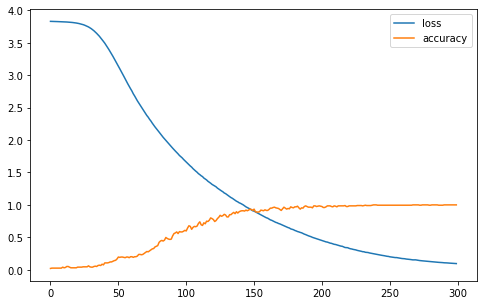

In [131]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

### Saving The Model , Tokenizer , Encoded Labels

In [132]:
import pickle

model.save("chat_model")

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('label_encoder.pickle', 'wb') as ecn_file:
    pickle.dump(lbl_encoder, ecn_file, protocol=pickle.HIGHEST_PROTOCOL)

INFO:tensorflow:Assets written to: chat_model/assets


### Build The Model WIth Another Optimizer 

In [133]:
model2 = Sequential()
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.25))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.25))
model2.add(Dense(num_classes, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model2.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [134]:
model2_nn = model2.fit(padded_sequences, np.array(training_labels), epochs=350, batch_size=5)

Epoch 1/350
40/40 [==============================] - 1s 2ms/step - loss: 6.5977 - accuracy: 0.0302
Epoch 2/350
40/40 [==============================] - 0s 2ms/step - loss: 3.8398 - accuracy: 0.0101
Epoch 3/350
40/40 [==============================] - 0s 2ms/step - loss: 3.9919 - accuracy: 0.0151
Epoch 4/350
40/40 [==============================] - 0s 2ms/step - loss: 3.9185 - accuracy: 0.0201
Epoch 5/350
40/40 [==============================] - 0s 2ms/step - loss: 3.9124 - accuracy: 0.0352
Epoch 6/350
40/40 [==============================] - 0s 2ms/step - loss: 3.8298 - accuracy: 0.0352
Epoch 7/350
40/40 [==============================] - 0s 2ms/step - loss: 3.8255 - accuracy: 0.0352
Epoch 8/350
40/40 [==============================] - 0s 2ms/step - loss: 3.8254 - accuracy: 0.0352
Epoch 9/350
40/40 [==============================] - 0s 2ms/step - loss: 3.8259 - accuracy: 0.0352
Epoch 10/350
40/40 [==============================] - 0s 3ms/step - loss: 3.8250 - accuracy: 0.0352
Epoch 11/

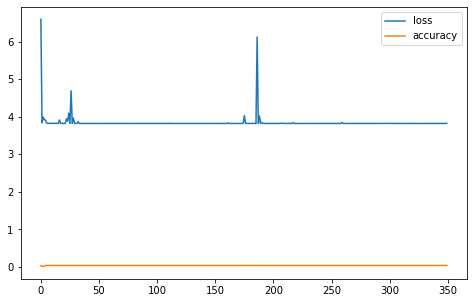

In [135]:
pd.DataFrame(model2_nn.history).plot(figsize=(8,5))
plt.show()

In [136]:
# import json 
# import numpy as np
# from tensorflow import keras
# from sklearn.preprocessing import LabelEncoder

# import colorama 
# colorama.init()
# from colorama import Fore, Style, Back

# import random
# import pickle

# with open("intents.json") as file:
#     data = json.load(file)


# def chat():
#     # load trained model
#     model = keras.models.load_model('chat_model')

#     # load tokenizer object
#     with open('tokenizer.pickle', 'rb') as handle:
#         tokenizer = pickle.load(handle)

#     # load label encoder object
#     with open('label_encoder.pickle', 'rb') as enc:
#         lbl_encoder = pickle.load(enc)

#     # parameters
#     max_len = 20
    
#     while True:
#         print(Fore.LIGHTBLUE_EX + "User: " + Style.RESET_ALL, end="")
#         inp = input()
#         if inp.lower() == "quit":
#             break

#         result = model.predict(keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([inp]),
#                                              truncating='post', maxlen=max_len))
#         tag = lbl_encoder.inverse_transform([np.argmax(result)])

#         for i in data['intents']:
#             if i['tag'] == tag:
#                 print(Fore.GREEN + "ChatBot:" + Style.RESET_ALL , np.random.choice(i['responses']))

#         # print(Fore.GREEN + "ChatBot:" + Style.RESET_ALL,random.choice(responses))

# print(Fore.YELLOW + "Start messaging with the bot (type quit to stop)!" + Style.RESET_ALL)
# chat()